In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline
#from scipy.interpolate import InterpolatedUnivariateSpline
from scipy.interpolate import interp1d
from astropy.cosmology import Planck15
from datetime import datetime
from decimal import Decimal
from scipy import stats
from datetime import datetime
import subprocess
c = 299792458 #speed of light m s^-1
plt.rcParams['figure.figsize'] = [20, 10]

startTime = datetime.now()

In [2]:
from os.path import expanduser
home = expanduser("~")

In [3]:
home

'/Users/cv'

In [4]:
libdir = home + '/sed_research'

def read_params(paramfile):
    params = {}
    params["Filters"] = {}
    with open(paramfile) as f:
        for line in f:
            #print line.split()
            if line[0] != "#":
                ls = line.split()
                params["Filters"][ls[0]] = {}
                params["Filters"][ls[0]]["lam_c"] = np.float(ls[1])
                params["Filters"][ls[0]]["delt_lam"] = np.float(ls[2])
                params["Filters"][ls[0]]["5sigma"] = np.float(ls[3])
                params["Filters"][ls[0]]["filename"] = libdir + "/Filters/" + ls[4]
                params["Filters"][ls[0]]["eazy_tag"] = np.float(ls[5])
    return params

In [5]:
class sed(object):
    "Spectral Energy Distribution Object"
    def __init__(self,paramfile,templatefile):
        params = read_params(paramfile)
        self.filters = params.get("Filters")
        template = templatefile
        self.loglam,self.lognuLnu = np.loadtxt(template,usecols=(0,1), delimiter=" ", unpack=True)
        self.nuLnu = np.power(10.,self.lognuLnu)
        self.lam = np.power(10.,self.loglam)
        self.template = self.nuLnu/self.lam #propto Flam at rest
        #loading filters
        for Filter in self.filters:
            lam,trans = np.loadtxt(self.filters[Filter]["filename"],usecols =(0,1),delimiter=" ",unpack=True)
            #Pass wavelength from Angstrom to microns
            self.filters[Filter]["lam"] = lam*1e-4
            self.filters[Filter]["trans"] = trans
            
    def redshift(self,z):
        #Applying a redshift
        self.z = z
        self.nuFnu = (self.nuLnu/(4.*np.pi*Planck15.luminosity_distance(z).value**2))
        self.lam_new = self.lam*(1.+z)
        
        self.Fnu = self.nuFnu*(self.lam_new*1e-6/c)*1e-10*1e23 #Fnu in Jy
        
        self.Flam = 1e6*c*(self.Fnu*1e-23)/self.lam_new**2 #Flam in erg cm-2 s-1 um-1
        #interpolation
        self.inuFnu = interp1d(self.lam_new,self.nuFnu)
        self.iFnu = interp1d(self.lam_new,self.Fnu)
        self.iFlam = interp1d(self.lam_new,self.Flam)
        
    def photometry(self):
        self.SNR = []
        self.phot_err = []
        self.phot_c = []
        self.phot = []
        self.lam_eff = []
        self.lam_c = []
        self.lam_err = []
        self.tag = []
        self.eazytag = []
        self.det = [] #Detections of upper_limits
        #Gets the photometry of all the filters
        for Filter in self.filters:
            lam = self.filters[Filter]["lam"]
            trans = self.filters[Filter]["trans"]
            #nuFnu = self.inuFnu(lam)
            Fnu = self.iFnu(lam)
            Flam = self.iFlam(lam)
            #Doing the integral for photometry - effective stimulus
            #This is the photometry
            #phot_c = np.trapz(nuFnu*trans,lam)/np.trapz(trans*lam,lam)
            #phot_c = np.trapz(nuFnu/lam*trans,lam)/np.trapz(trans,lam)
            #photlam = np.trapz(Flam*trans,lam)/np.trapz(trans*lam,lam)
            #lam_pivot = np.sqrt((np.trapz(trans,lam))/(np.trapz(trans/(lam**2),lam)))
                                    #(um to m)  (erg s-1 cm-2 Hz-1 to Jy)
            #phot_c = (lam_pivot**2)*(photlam/c)*(1e-6)*(1e23) 
            
            #phot_lam = np.trapz(Flam*trans*lam,lam)/np.trapz(trans*lam,lam)
            
            #lam_eff = np.trapz(Flam*trans*lam**2)/np.trapz(Flam*trans*lam,lam)
            
            #phot_c = 1e-6*(phot_lam*lam_eff**2)/c
            
            phot_lam = np.trapz(Flam*trans,lam)/np.trapz(trans,lam)
            lam_pivot = np.sqrt(np.trapz(trans,lam)/np.trapz(trans/lam**2,lam))
            phot_c = 1e17*(lam_pivot**2)*phot_lam/c
            
            self.phot_c.append(phot_c)
            
            #Calculating sigma_flux in Jy
            
            fivesigma_mag = self.filters[Filter]["5sigma"]
            
            sigma_flux = (10**(-(fivesigma_mag + 48.6)/2.5)*1e23)/5.
            
            #Random realization
            phot = np.random.normal(loc=phot_c,scale=sigma_flux)
            
            if phot<0:
                phot=0.
            
            #self.phot.append(phot)
            
            #Calculating SNR
            SNR = phot/sigma_flux
            self.SNR.append(SNR)
            
            #print "{}    {}    {}    {}".format(Filter,sigma_flux,phot,SNR)
            
            if SNR>3.:
                self.det.append("det")
                self.phot_err.append(sigma_flux)
                self.phot.append(phot)
            #Treatment of non detections
            else:
                self.det.append("up_lim")
                #Adding the treatment of 3/2
                
                phot = (3./2.)*sigma_flux
                phot_err = (3./2.)*sigma_flux
                
                #Randomizing the value
                #phot = np.random.normal(loc=phot,scale=phot_err)
                self.phot.append(phot)
                self.phot_err.append(phot_err)
                
            #Doing the integral for effective wavelength
            #lam_eff = np.trapz(Fnu*trans*lam*lam,lam)/np.trapz(Fnu*trans*lam,lam)
            #lam_eff = np.trapz(nuFnu*trans*lam,lam)/np.trapz(nuFnu*trans,lam)
            self.lam_eff.append(lam_pivot)
            self.lam_c.append(self.filters[Filter]["lam_c"])
            self.lam_err.append(self.filters[Filter]["delt_lam"]/2.)
            self.tag.append(Filter)
            self.eazytag.append(self.filters[Filter]["eazy_tag"])
            #print SNR
            
    def plot_sed(self,scale="normal",color="blue",linewidth=0.5):
        #Plotting the SED and the possible Photometry
        #plt.title("mysed; z={}".format(self.z))
        plt.ylabel(r"$F_{\nu}$[Jy]")
        plt.xlabel("$\lambda$ [$\mu$m]")
        if scale=="normal":
            plt.plot(self.lam_new,self.iFnu(self.lam_new),color=color,linewidth=linewidth,label="{}".format(self.z))
        if scale=="loglog":
            plt.loglog(self.lam_new,self.iFnu(self.lam_new),color=color,label="{}".format(self.z))
        
    def plot_filters(self,norm):
        for Filter in self.filters:
            lam = mysed.filters[Filter]["lam"]
            trans = mysed.filters[Filter]["trans"]*norm
            plt.plot(lam,trans,label = Filter)
            
    def export_phot(self,program="EAZY"):
        idx = np.argsort(np.asarray(self.lam_c))
        phot = np.asarray(self.phot)[idx]
        phot_err = np.asarray(self.phot_err)[idx]
        tag = np.asarray(self.tag)[idx]
        eazytag = np.asarray(self.eazytag)[idx]
        if program=="EAZY":
            return phot, phot_err, tag, eazytag
    def export_template(self,filename,folder):
        with open(folder+filename,"w") as f:
            for i in range(len(self.lam)-1):
                f.write("{} {}\n".format(1e4*self.lam[i],self.template[i]))

In [6]:
parfile = libdir + '/params/nir.par'
tempfile = libdir + '/Templates/ARP220_loglam_lognuLnu.txt'

In [7]:
#Initializing here, so we don't have to call the class every time

z = 2.5
mysed = sed(parfile,tempfile)
mysed.redshift(z)
mysed.photometry()
phot, phot_err, tag, eazytag = mysed.export_phot(program="EAZY")


In [8]:
folder = home + "/eazy-photoz/templates/vb/"
filename = "ARP220.dat"
mysed.export_template(filename,folder)

In [9]:
mysed.template[len(mysed.template)-1]

1.791407622239806e-06

In [10]:
#%matplotlib auto

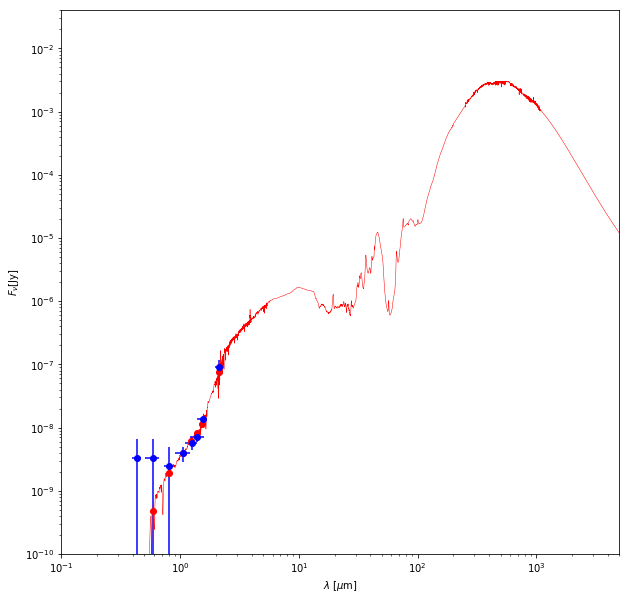

In [35]:
z = 4.9
mysed = sed(parfile,tempfile)
mysed.redshift(z)
mysed.photometry()

ax = plt.subplot(111)
ax.set_xscale("log", nonposx='clip')
ax.set_yscale("log", nonposy='clip')

plt.errorbar(mysed.lam_c, mysed.phot, xerr=mysed.lam_err, yerr=mysed.phot_err,fmt="bo",ecolor="blue")
plt.plot(mysed.lam_eff, mysed.phot_c, "ro")
mysed.plot_sed(scale="normal",color="red")
#plt.plot(mysed.lam_eff,mysed.phot_c,"ro")

#test 
#plt.errorbar(lam_c,phot_test,yerr=phot_err_test,fmt="co")

#mysed.plot_filters(1e-8)
plt.ylim(1e-10,4e-2)
plt.xlim(1e-1,5e3)
#plt.legend(loc="lower right")



plt.show()

In [12]:
#Translation from name to filters on EAZY FILTER.RES
eazyfolder = home + "/eazy-photoz"
with open(eazyfolder + "/inputs/zphot.translate","w") as f:
    for i in range(len(eazytag)):
        f.write("f_{} F{}\n".format(str(tag[i]),str(int(eazytag[i]))))
        f.write("e_{} E{}\n".format(str(tag[i]),str(int(eazytag[i]))))

In [13]:
#Creating a Mock catalog
zspace = np.linspace(1.,5.,10000) #Redshift grid

In [14]:
with open(home + "/eazy-photoz/inputs/eazy.cat","w") as f:
    L = "#id"
    for i in range(len(tag)):
        L+= " f_{} e_{}".format(tag[i],tag[i])
#    f.write(L + " z_spec" + "\n")
    f.write(L + "\n")
    L = "#id"
    for i in range(len(eazytag)):
        L+= " F{} E{}".format(np.int(eazytag[i]),np.int(eazytag[i]))
#    f.write(L + " z_spec" + "\n")
    f.write(L + "\n")
    for i in range(len(zspace)):
        mysed.redshift(zspace[i])
        mysed.photometry()
        phot, phot_err, tag, eazytag = mysed.export_phot(program="EAZY")
        L = "{}".format(i+1)
        for j in range(len(phot)):
            #EAZY format for Flux is microJansky
            L += "  " + "{:.5e}".format(Decimal(str(1e6*phot[j]))) + "  " + "{:.5e}".format(Decimal(str(1e6*phot_err[j])))
#        L+= " -1.0000"
        L+= "\n"
        f.write(L)
    print "done"

done


In [15]:
#Running EAZY from here
os.chdir(home + "/eazy-photoz/inputs/")
subprocess.call("../src/eazy -p zphot.param.default",shell=True)

0

In [16]:
zout = np.loadtxt(home + "/eazy-photoz/inputs/OUTPUT/photz.zout",comments="#",usecols=(14),unpack=True)

In [17]:
zout

array([1.0068, 1.0068, 0.9869, ..., 0.7802, 5.2522, 3.5398])

In [18]:
plt.rcParams['figure.figsize'] = [10, 10]

In [26]:
zspace[8000]

4.200320032003201

1.0138601759496308 -0.012583860232647792


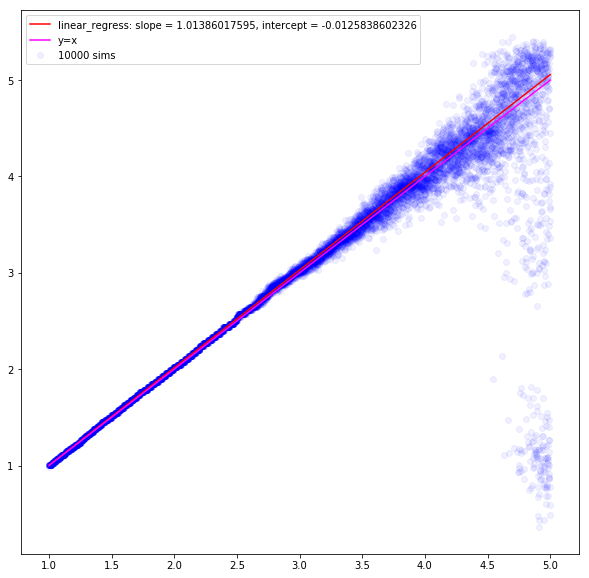

In [33]:
slope, intercept, r_value, p_value, std_err = stats.linregress(zspace[:3000],zout[:3000])
x = np.linspace(1.,5.,10000)
y = slope*x+intercept
plt.plot(x,y,color="red",label="linear_regress: slope = {}, intercept = {}".format(slope,intercept))
print slope,intercept

plt.plot(x,x,color="magenta",label="y=x")

plt.scatter(zspace,zout,c="blue",alpha=0.06,label="10000 sims")
plt.legend()
plt.show()

In [20]:
phot_test = np.array([1.70771e-01,1.91405e+00,5.69421e+00,3.25895e+01,8.45730e+01,1.19146e+02,1.57714e+02])*1e-6
phot_err_test = np.array([7.44628e-02,3.79339e-02,2.65289e-02,4.55096e-02,5.64738e-01,9.86226e-01,9.14601e-01])*1e-6
lam_c = np.array([2.9928e+03,4.5573e+03,6.0013e+03,7.9960e+03,1.2289e+04,1.6444e+04,2.2124e+04])*1e-4

In [21]:
#%matplotlib auto

In [22]:
"""
lam2,Flam2 = np.loadtxt(home + "/eazy-photoz/templates/vb/Arp220_template_norm.sed",unpack=True)
nuFnu2 = Flam2*lam2
lam2um = lam2*1e-4

nu2 = c/(lam2*1e-10)

Fnu2 = nuFnu2/nu2*1e23*160./6.1e15

plt.loglog(lam2um,Fnu2,"r-",markersize=0.5)
plt.xlabel(r"$\lambda [\mu m]$")
plt.ylabel(r"$F\nu$ $[Jy]$")

z = 0.0185
mysed = sed(parfile,tempfile)
mysed.redshift(z)
mysed.photometry()

ax = plt.subplot(111)
ax.set_xscale("log", nonposx='clip')
ax.set_yscale("log", nonposy='clip')

plt.errorbar(mysed.lam_c, mysed.phot, xerr=mysed.lam_err, yerr=mysed.phot_err,fmt="bo",ecolor="blue")
plt.plot(mysed.lam_eff, mysed.phot_c, "ro")
mysed.plot_sed(scale="normal",color="red")

plt.show()
"""

'\nlam2,Flam2 = np.loadtxt(home + "/eazy-photoz/templates/vb/Arp220_template_norm.sed",unpack=True)\nnuFnu2 = Flam2*lam2\nlam2um = lam2*1e-4\n\nnu2 = c/(lam2*1e-10)\n\nFnu2 = nuFnu2/nu2*1e23*160./6.1e15\n\nplt.loglog(lam2um,Fnu2,"r-",markersize=0.5)\nplt.xlabel(r"$\\lambda [\\mu m]$")\nplt.ylabel(r"$F\nu$ $[Jy]$")\n\nz = 0.0185\nmysed = sed(parfile,tempfile)\nmysed.redshift(z)\nmysed.photometry()\n\nax = plt.subplot(111)\nax.set_xscale("log", nonposx=\'clip\')\nax.set_yscale("log", nonposy=\'clip\')\n\nplt.errorbar(mysed.lam_c, mysed.phot, xerr=mysed.lam_err, yerr=mysed.phot_err,fmt="bo",ecolor="blue")\nplt.plot(mysed.lam_eff, mysed.phot_c, "ro")\nmysed.plot_sed(scale="normal",color="red")\n\nplt.show()\n'

In [23]:
print datetime.now() - startTime

0:06:13.006602


In [24]:
tau_ign = 0.805*((1.+z_L)**3)*((1./(1.+z_L)) - (1./(1+z)) )

NameError: name 'z_L' is not defined

In [ ]:
def tau_ign(z):
    lam = np.linspace(1000.,6000.,1000)
    lam_L = 912.
    z_L = lam/lam_L
    return lam,0.805*((1.+z_L)**3)*((1./(1.+z_L)) - (1./(1.+z)) )

In [ ]:
lam,tau = tau_ign(1.)

In [ ]:
plt.plot(lam,np.exp(tau),"ro")
plt.show()